# Project 2: 2-node Network Data

Instructions:
Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.

(1) Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.

(2) What can you infer about each of the distinct groups?

## Data

ROSENFELD,WHITE--ST. LOUIS CRIME
DATASETS CRIME SEX

DESCRIPTION One 870×557 two mode valued matrix of individuals by involvement in crime events. One 870×1 vector displaying the sex of each individual.

CRIME two mode, valued
SEX vector reporting sex of each individual.
BACKGROUND In the 1990s Rick Rosenfeld and Norm White used police records to collect data on crime in St. Louis. They began with five homicides and recorded the names of all the individuals who had been involved as victims, suspects or witnesses. They then explored the files and recorded all the other crimes in which those same individuals appeared. This snowball process was continued until they had data on 557 crime events. Those events involved 870 participants of which: 569 appeared as victims 682 appeared as suspects 195 appeared as witnesses, and 41 were dual (they were recorded both as victims and suspects in the same crime. Their data appear, then, as an 870 by 557, individual by crime event matrix. Victims are coded as 1, suspects as 2, witnesses as 3 and duals as 4.
In addition Rosenfeld and White recorded the sex of each individual.

Link: http://moreno.ss.uci.edu/data.html#crime

## Packages used

In [1]:
import requests
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt

## Functions for Parsing Data

In [32]:
def extract_string(string:str) -> str:
    '''
    input: string
    output: string
    function cleans up string
    '''
    return string.replace('\r', '').replace('"','')

def extract_int(string:str) -> int:
    '''
    input: string
    output: integer
    function cleans up string, transforms to integer
    '''
    return int(string.replace('\r', '').replace('"','').strip())

## Call Sex Data and Produce Data Frame

In [56]:
#Extract sex data from UCI website
response = requests.get('http://moreno.ss.uci.edu/sex.dat')
data = response.text 
data_by_line = data.split('\n')

#create list of names
#first name: "AbelDennis" first
#last name: RunyonMatt
name_list = []
for name in data_by_line[4:875]:
    name_list.append(extract_string(name))

#create list of sex    
sex_list = []
for sex in data_by_line[878:-1]:
    sex_list.append(extract_int(sex))

#create dataframe concatenating informaiton
sex_df = pd.DataFrame({'name': name_list, 'sex': sex_list})
sex_df

,name,sex
0,AbelDennis,1
1,AbramsChad,1
2,AbramsDavid,1
3,AbramsDon,1
4,AbramsRichard,1
...,...,...
866,YatesAugust,1
867,YorkBrant,1
868,ParkerPete,1
869,DandyCarol,0


## Call Crime Data and Produce Data Frame 

In [175]:
response = requests.get('http://moreno.ss.uci.edu/crime.dat')
data = response.text 
data_by_line = data.split('\n')
#  870

# #first name: "AbelDennis" first
# #last name: RunyonMatt
row_idx_name_2 = []
for i in data_by_line[4:874]:
    row_idx_name_2.append(extract_string(i))


# #first column: 920001
# #last column: 970556
column_headers_list = []
for i in data_by_line[875:1432]:
    column_headers_list.append(extract_int(i))

#crime data
crime_data_list = []
for crime in data_by_line[1433:-1]:
    crime_string = extract_string(crime)
    #split string and convert to list of integers
    crime_list = []
    for i in crime_string.split():
        crime_list.append(i)    
    crime_data_list.append(crime_list)
    

#unique identifier
unique_id_df = pd.DataFrame(list(range(0,len(crime_data_df['name']))))

# Create the pandas DataFrame  
crime_df = pd.DataFrame(crime_data_list, columns = column_headers_list) 
crime_df.insert(0,'name',row_idx_name_2)
crime_df.insert(0,'node',unique_id_df)
crime_df

,node,name,920001,930002,930003,930004,930005,930006,930007,930008,...,970547,970548,970549,970550,970551,970552,970553,970554,970555,970556
0,0,AbelDennis,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,AbramsChad,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,AbramsDavid,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,AbramsDon,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,AbramsRichard,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
865,865,YatesAugust,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
866,866,YorkBrant,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
867,867,ParkerPete,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
868,868,DandyCarol,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Link Sex and Crime Data

In [176]:
crime_sex_df = pd.merge(sex_df, crime_df, on='name')
crime_sex_df

,name,sex,node,920001,930002,930003,930004,930005,930006,930007,...,970547,970548,970549,970550,970551,970552,970553,970554,970555,970556
0,AbelDennis,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AbramsChad,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AbramsDavid,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AbramsDon,1,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AbramsRichard,1,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,YatesAugust,1,865,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
867,YorkBrant,1,866,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
868,ParkerPete,1,867,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
869,DandyCarol,0,868,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Send data to csv

In [39]:
##Send Data to csv
crime_sex_df.to_csv('crime_sex_data.csv', header=True, index=False)

## Ensure CSV File is created properly.

In [163]:
crime_data_df = pd.read_csv('crime_sex_data.csv')
crime_data_df

,name,sex,node,920001,930002,930003,930004,930005,930006,930007,...,970547,970548,970549,970550,970551,970552,970553,970554,970555,970556
0,AbelDennis,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AbramsChad,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AbramsDavid,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AbramsDon,1,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AbramsRichard,1,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,YatesAugust,1,865,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
867,YorkBrant,1,866,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
868,ParkerPete,1,867,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
869,DandyCarol,0,868,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


need: node, sex, column name, value

In [177]:
#Create list of all the incidents
incident_list = list(crime_data_df.columns.values)

#remove uncessary names and bad data
incident_list.remove('name')
incident_list.remove('sex')
incident_list.remove('node')
incident_list.remove('960267.1')
incident_list.remove('960247.1')
incident_list.remove('950203')

# #initialize empty array for node edge pairs
bipart_data_structure = []

for incident in incident_list:

    #create data frame with just node, sex, and incident
    incident_df = crime_data_df[['node','sex', incident]]

    #extract rows with values greater than 0
    incident_compressed_df = incident_df[(incident_df > 0).all(axis=1)]

    #create a list from the data frame
    incident_compressed_list = incident_compressed_df.values.tolist()
    incident_compressed_list

    for person in incident_compressed_list:
        person.append(incident)
        bipart_data_structure.append(person)

bipart_data_structure
bipart_data_structure_df = pd.DataFrame(bipart_data_structure, columns = ['node', 'sex', 'relationship', 'incident'])   
bipart_data_structure_df

,node,sex,relationship,incident
0,111,1,1,920001
1,614,1,1,930002
2,137,1,2,930003
3,58,1,1,930004
4,79,1,2,930004
...,...,...,...,...
1021,55,1,2,970556
1022,56,1,2,970556
1023,446,1,2,970556
1024,469,1,2,970556


## Victims are coded as 1, suspects as 2, witnesses as 3 and duals as 4.

In [183]:
#bring in the data name
crime_data_df
bipart_data_structure_df
bipart_data_df = pd.merge(bipart_data_structure_df, crime_data_df, on='node')
bipart_data_df = bipart_data_df[['name','node','sex_x','relationship','incident']]
bipart_data_df.to_csv('bipart_crime_data.csv')
bipart_data_df

,name,node,sex_x,relationship,incident
0,BrowningCalder,111,1,1,920001
1,BrowningCalder,111,1,1,930014
2,BrowningCalder,111,1,1,930020
3,BrowningCalder,111,1,1,960369
4,BrowningCalder,111,1,1,960386
...,...,...,...,...,...
1021,FieldsWalter,272,1,1,970548
1022,DeaconHubert,219,1,2,970553
1023,LaddClarence,473,1,4,970554
1024,BenderCarlos,55,1,2,970556


In [3]:
#Prepare edge data
edges = pd.read_csv('bipart_crime_data.csv')
edges['weight'] = 1
edges = edges[['name','sex_x','relationship','incident','weight']]
edges = edges.rename(columns={'name': 'source', 'sex_x':'source_sex', 'incident':'target', 'relationship':'value'})

In [4]:
#create graph and add edges
g = nx.from_pandas_edgelist(edges, edge_attr=True)

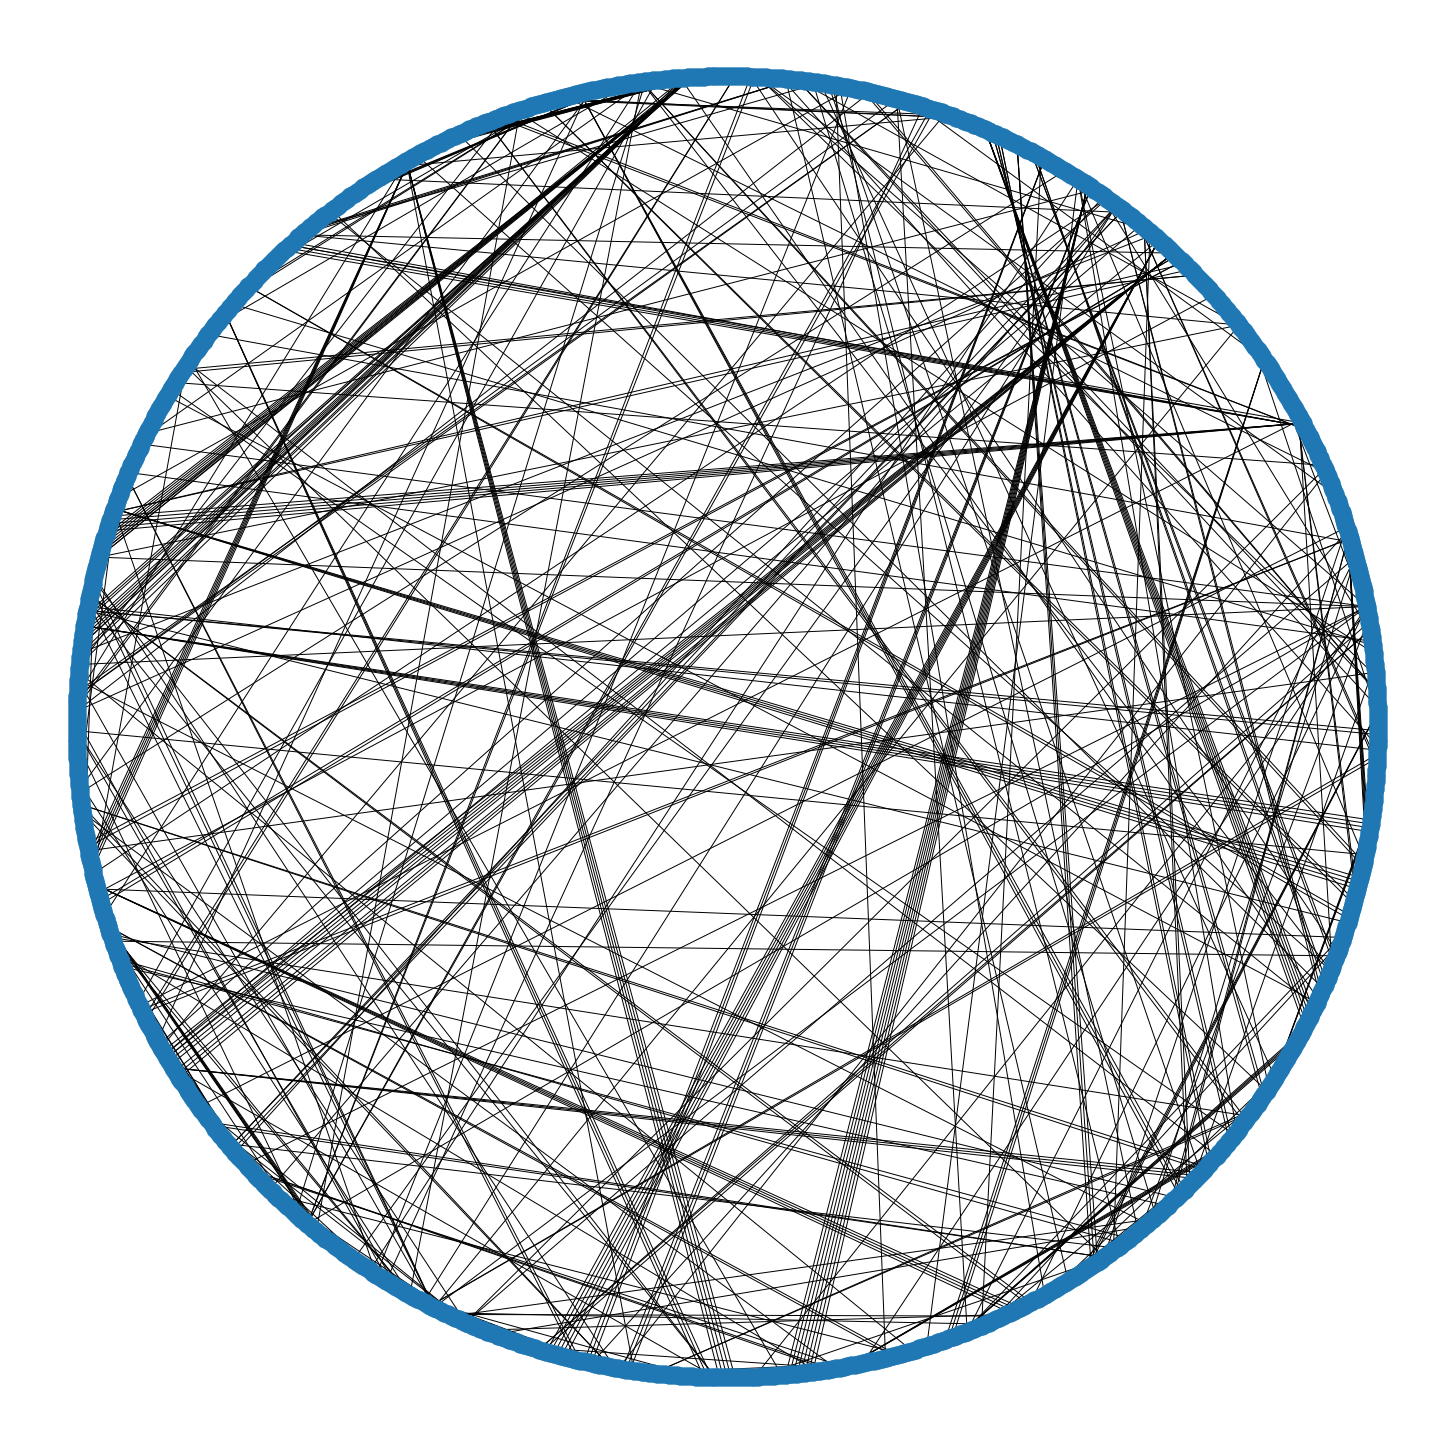

In [5]:
#Generate graph
plt.figure(figsize=(20,20))  
nx.draw_circular(g)
#too dense, may have to use snowball sampling 

PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')